In [1]:
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from ALLCools.integration import calculate_overlap_score
from wmb import cemba, aibs, brain

import pathlib
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
dataset = 'AIBS_SMART'
categorical_key = ['L1_annot', 'L2', 'DissectionRegion']

## Load

In [3]:
mc_annot = cemba.get_mc_annot()

In [4]:
if dataset == 'AIBS_SMART':
    rna_annot = aibs.get_smart_annot()
elif dataset == 'AIBS_TENX':
    rna_annot = aibs.get_tenx_annot()
else:
    raise ValueError

In [5]:
adata_merge = anndata.read_h5ad('final_with_coords.h5ad')

In [6]:
adata_merge

AnnData object with n_obs × n_vars = 10000 × 3318
    obs: 'count', 'read_count', 'n_counts', 'Modality', 'DissectionRegion', 'L1_annot', 'L2', 'L1_annot_transfer', 'L2_transfer', 'DissectionRegion_transfer', 'leiden'
    var: 'chrom', 'end-RNA', 'start-RNA', 'mean-RNA', 'std-RNA', 'cov_mean-mC', 'end-mC', 'start-mC'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_harmony', 'X_pca_integrate', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [7]:
mc_adata = adata_merge[adata_merge.obs['Modality'] == 'mC'].copy()
rna_adata = adata_merge[adata_merge.obs['Modality'] == 'RNA'].copy()

In [8]:
rna_meta = adata_merge.obs[adata_merge.obs['Modality'] == 'RNA'].copy()
mc_meta = adata_merge.obs[adata_merge.obs['Modality'] == 'mC'].copy()

## Scatter

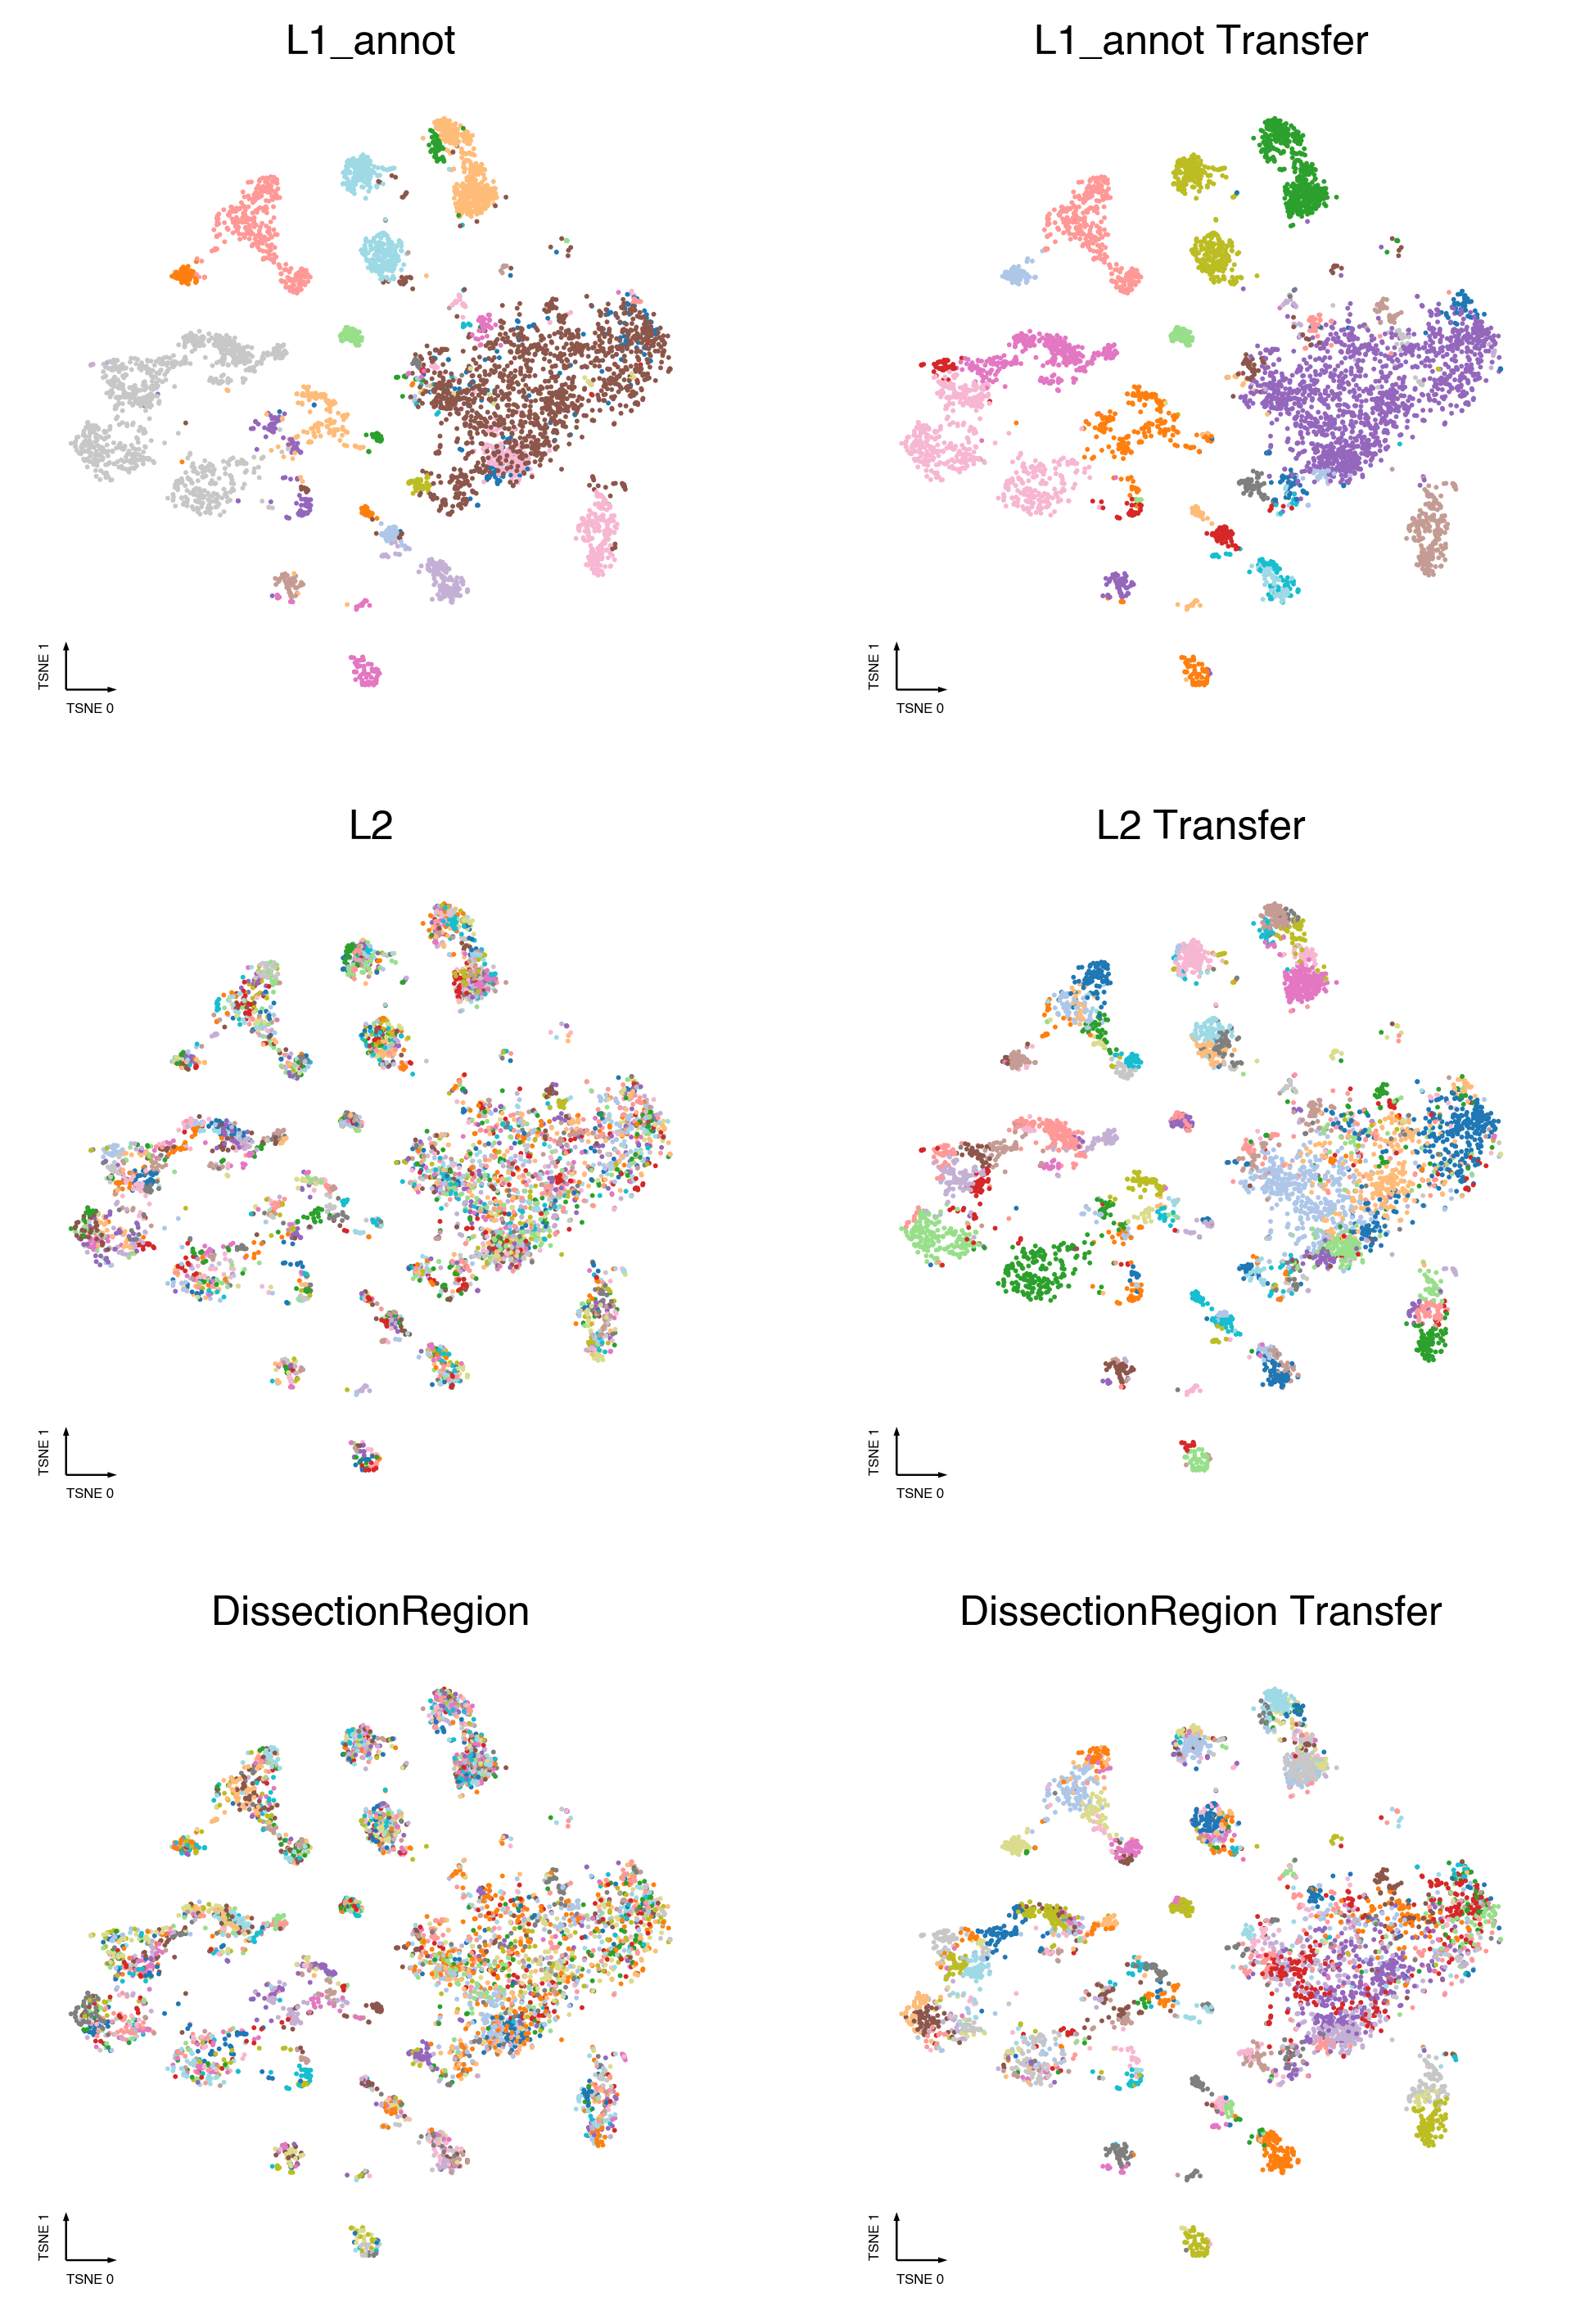

In [9]:
fig, axes = plt.subplots(figsize=(8, 4 * len(categorical_key)),
                         dpi=300,
                         ncols=2,
                         nrows=len(categorical_key))

for ax_row, cat_key in zip(axes, categorical_key):
    ax = ax_row[0]
    if rna_meta[cat_key].unique(
    ).size > 30 or rna_meta[f'{cat_key}_transfer'].unique().size > 30:
        text_anno = False
    else:
        text_anno = True

    categorical_scatter(ax=ax,
                        data=rna_adata,
                        coord_base='tsne',
                        palette='tab20',
                        text_anno=rna_meta[cat_key] if text_anno else None,
                        hue=rna_meta[cat_key],
                        max_points=None)
    ax.set(title=cat_key)

    ax = ax_row[1]
    categorical_scatter(
        ax=ax,
        data=rna_adata,
        coord_base='tsne',
        palette='tab20',
        text_anno=rna_meta[f'{cat_key}_transfer'] if text_anno else None,
        hue=rna_meta[f'{cat_key}_transfer'],
        max_points=None)
    ax.set(title=f'{cat_key} Transfer')

## Confusion Matrix Based On Label Transfer

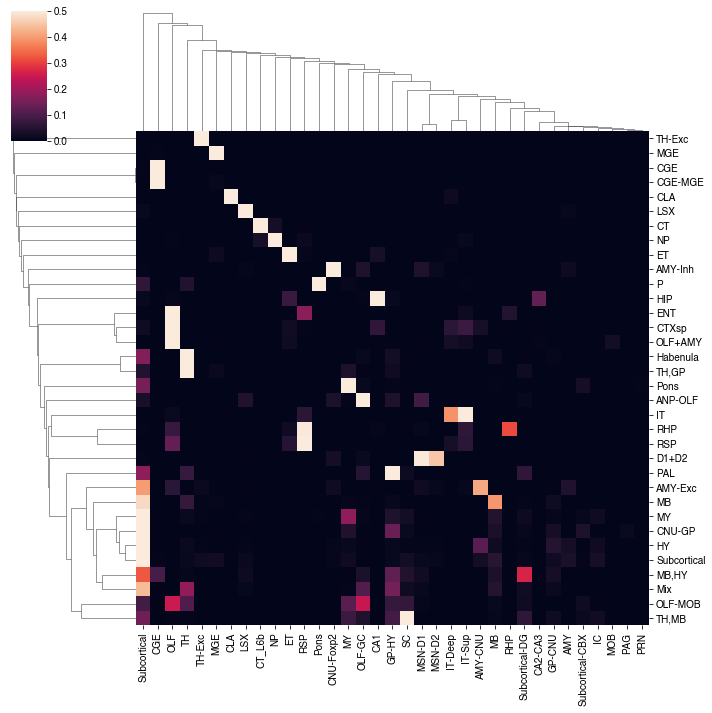

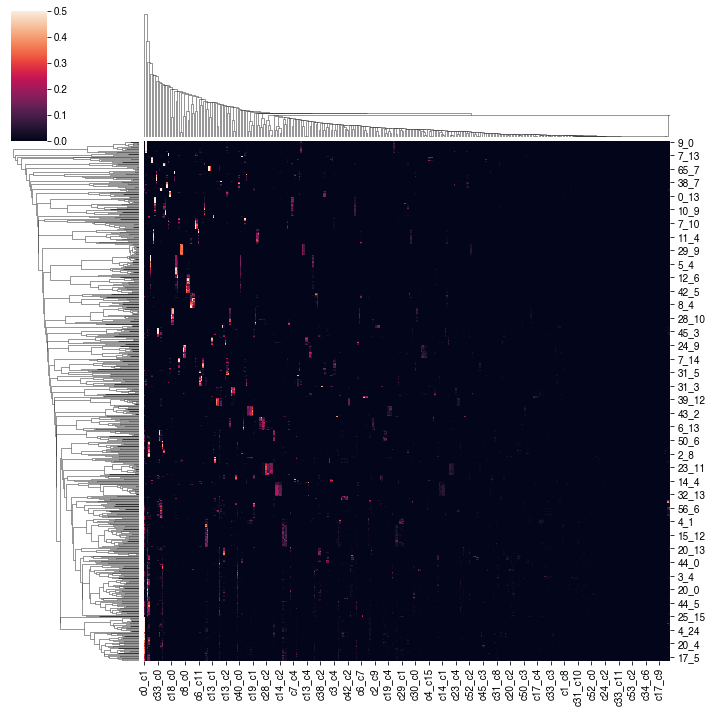

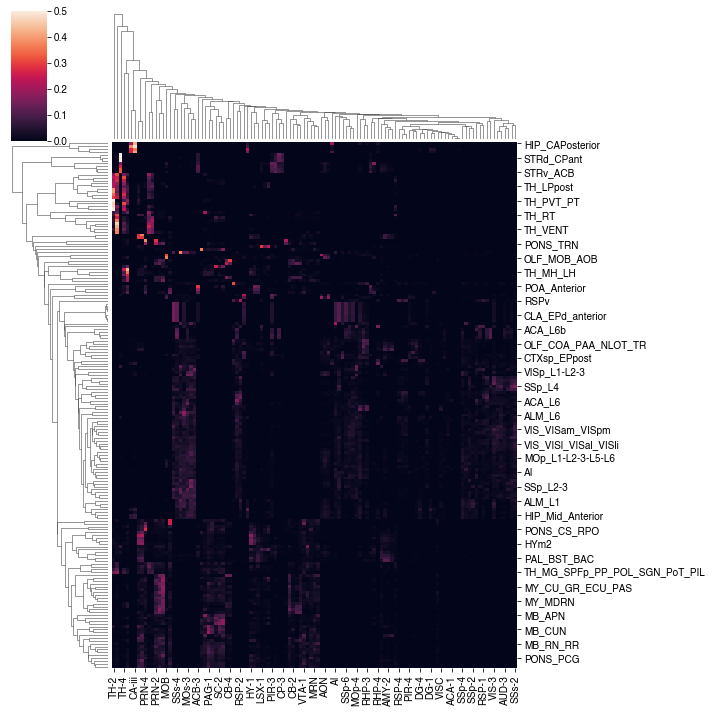

In [10]:
for cat_key in categorical_key:
    label_transfer = pd.read_hdf(f'{cat_key}_transfer.hdf')
    label_confusion = label_transfer.groupby(
        rna_annot[cat_key].to_pandas().astype(str)).mean()
    label_confusion.to_hdf(f'{cat_key}.label_transfer.confusion.hdf', key='data')
    if label_confusion.shape[1] == 1 or label_confusion.shape[0] == 1:pass
    else:g = sns.clustermap(data=label_confusion, vmax=0.5)

## Confusion Matrix Based On Co-clustering Overlap Score

In [11]:
rna_meta['cocluster'] = adata_merge.obs['leiden']
mc_meta['cocluster'] = adata_merge.obs['leiden']

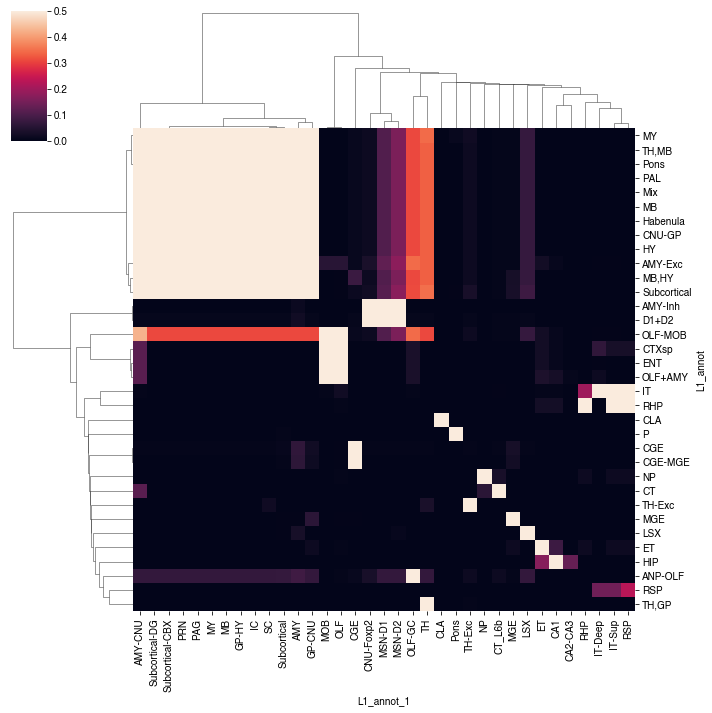

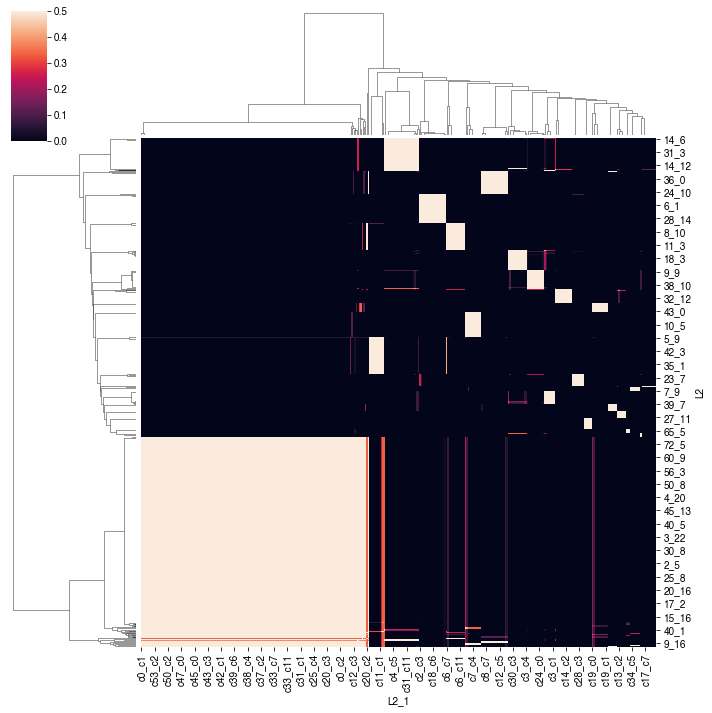

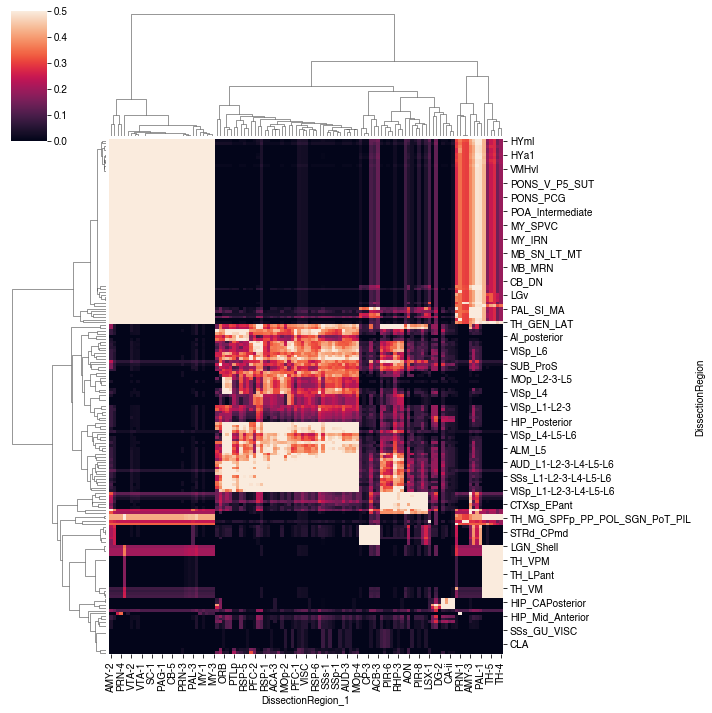

In [12]:
for cat_key in categorical_key:
    os_mat = calculate_overlap_score(rna_meta[[cat_key, 'leiden']],
                                     mc_meta[[cat_key, 'leiden']])
    os_mat.to_hdf(f'{cat_key}.overlap_score.hdf', key='data')
    if os_mat.shape[1] == 1 or os_mat.shape[0] == 1:pass
    else:g = sns.clustermap(data=os_mat, vmax=0.5)

In [ ]:
!touch finish